# Joins

This chapter covers not just what joins exits in Spark and how to use them, but some of the basic internals so that we can think about how Spark actually goes about executing the join on the cluster. This basic knowledge can help us avoid runnning out of memory and tackle problems that we could face.

## Join Expressions

A join brings together two sets of data, the left and the right , by comparing the value of one ore more keys of the left and right and evaluating the result of a join expression that determines whether Spark should bring together the left set of data with the right set of data.

Join expression determines whether two rows should join.

## Join Types

The join type determines what should be in the result set. There are variety of different joins types available in Spark:

- Inner joins (keep rows with keys that exists in the left and right datasets)
- Outer joins (keep rows with keys in either the left or right dataset)
- Left outer joins (keep rows with keys in the left dataset)
- Right outer joins (keep rows with keys in the right dataset)
- Left semi joins (A left semi join in PySpark returns all rows from the left DataFrame where the join condition matches in the right DataFrame, but it only includes columns from the left DataFrame. )
- Left anti joins ( It returns rows from the left DataFrame that do not have any matching rows in the right DataFrame, based on the join condition.
)
-  Natural joins (A natural join automatically joins two tables on all columns with the same name. In PySpark, you need to explicitly specify the join columns or replicate the behavior manually.
)
- Cross (or Cartesian) joins (match every row in the left dataset with every row in the right dataset)

## Challenges When Using Joins


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr

In [2]:
sparkSession = SparkSession.builder.appName("Chapter 07 Learning").getOrCreate()
sparkSession.sparkContext

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/10 20:10:44 WARN Utils: Your hostname, alex-mathew, resolves to a loopback address: 127.0.1.1; using 192.168.1.14 instead (on interface wlo1)
25/12/10 20:10:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/10 20:10:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<SparkContext master=local[*] appName=Chapter 07 Learning>

In [3]:
# Create Person DataFrame
person = sparkSession.createDataFrame([
    (0, "Bill Chambers", 0, [100]),
    (1, "Matei Zaharia", 1, [500, 250, 100]),
    (2, "Michael Armbrust", 1, [250, 100])
]).toDF("id", "name", "graduate_program", "spark_status")
 
# Create Graduate Program DataFrame
graduateProgram = sparkSession.createDataFrame([
    (0, "Masters", "School of Information", "UC Berkeley"),
    (2, "Masters", "EECS", "UC Berkeley"),
    (1, "Ph.D.", "EECS", "UC Berkeley")
]).toDF("id", "degree", "department", "school")
 
# Create Spark Status DataFrame
sparkStatus = sparkSession.createDataFrame([
    (500, "Vice President"),
    (250, "PMC Member"),
    (100, "Contributor")
]).toDF("id", "status")

### Joins on Complex Types

In [5]:
person2 = person.withColumnRenamed("id", "personID")
person2.join(sparkStatus, expr("array_contains(spark_status, id)")).show()

+--------+----------------+----------------+---------------+---+--------------+
|personID|            name|graduate_program|   spark_status| id|        status|
+--------+----------------+----------------+---------------+---+--------------+
|       0|   Bill Chambers|               0|          [100]|100|   Contributor|
|       1|   Matei Zaharia|               1|[500, 250, 100]|500|Vice President|
|       1|   Matei Zaharia|               1|[500, 250, 100]|250|    PMC Member|
|       1|   Matei Zaharia|               1|[500, 250, 100]|100|   Contributor|
|       2|Michael Armbrust|               1|     [250, 100]|250|    PMC Member|
|       2|Michael Armbrust|               1|     [250, 100]|100|   Contributor|
+--------+----------------+----------------+---------------+---+--------------+



### Handling Duplicate Column Names

#### Approach 1: Different join expression

When you have two keys that have the same name, probably the easiest fix is to
change the join expression from a Boolean expression to a string or sequence. This
automatically removes one of the columns for you during the join:

#### Approach 2: Dropping the column after the join

Another approach is to drop the offending column after the join. When doing this,
we need to refer to the column via the original source DataFrame. 

#### Approach 3: Renaming a column before the join

We can avoid this issue altogether if we rename one of our columns before the join

## How Spark Performs Joins

To understand how Spark performs joins, we need to understand the two core resources at play: the **node-to-node** communication strategy and per **node computation** strategy. 

### Communication Strategies

Spark approaches cluster communication in two different ways during joins. It either
incurs a shuffle join, which results in an all-to-all communication or a broadcast join.

The core foundation of our simplified view of joins is that in Spark you will have either a big table or a small table.

#### Big table–to–big table

When you join a big table to another big table, you end up with a shuffle join, such as
that illustrates in Figure 8-1.

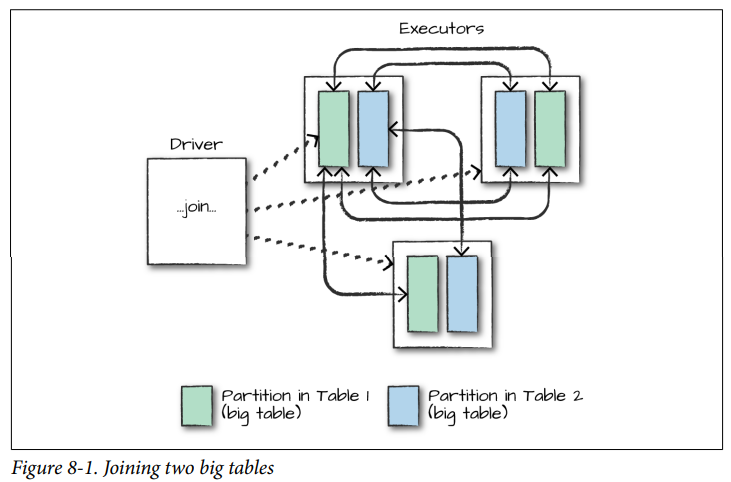

In a shuffle join, every node talks to every other node and they share data according
to which node has a certain key or set of keys (on which you are joining). These joins are expensive because the network can become congested with traffic, especially if
your data is not partitioned well.

#### Big table–to–small table

When the table is small enough to fit into the memory of a single worker node, with
some breathing room of course, we can optimize our join. Although we can use a big
table–to–big table communication strategy, it can often be more efficient to use a
broadcast join. What this means is that we will replicate our small DataFrame onto
every worker node in the cluster (be it located on one machine or many). 

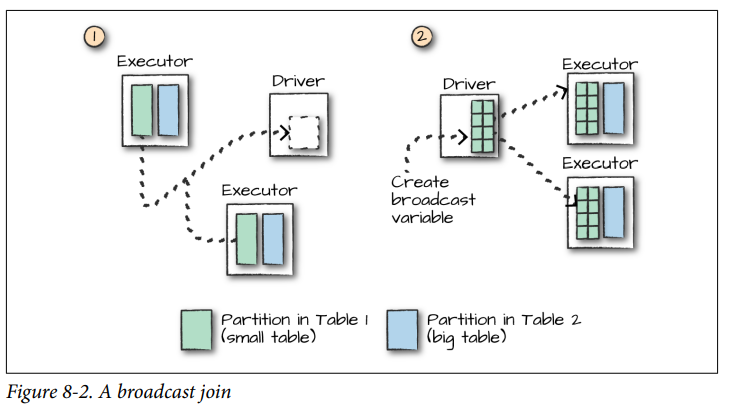

At the beginning of this join will be a large communication, just like in the previous
type of join. However, immediately after that first, there will be no further communication between nodes. This means that joins will be performed on every single node
individually, making CPU the biggest bottleneck. 